In [1]:
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# Interpret scikit-learn machine learning models

## Dataset: Current Population Survey (1985)

We will use data from the "Current Population Survey" from 1985 and fetch it from [OpenML](http://openml.org/).

In [4]:
from sklearn.datasets import fetch_openml

censing = fetch_openml(data_id=534, return_frame=True)
censing.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

We can get more information regarding by looking at the description of the dataset.

In [5]:
print(censing.DESCR)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

Determinants of Wages from the 1985 Current Population Survey

Summary:
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. We wish to determine (i) whether wages are related to these characteristics and (ii) whether there is a gender gap in wages.
Based on residual plots, wages were log-transformed to stabilize the variance. Age and work experience were almost perfectly correlated (r=.98). Multiple regression of log wages against sex, age, years of education, work experience, union membership, southern residence, and occupational status showed that these covariates were related to wages (pooled F test, 

The data are stored in a pandas dataframe.

In [6]:
censing.data.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR,WAGE
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married,5.10
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married,4.95
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried,6.67
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried,4.00
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married,7.50


In [7]:
censing.target_names

['WAGE']

The column **WAGE** is our target variable (i.e., the variable which we want to predict). You can note that the dataset contains both numerical and categorical data.

First, let's get some insights by looking at the **marginal** links between the different variables. Only *numerical* variables will be used. 

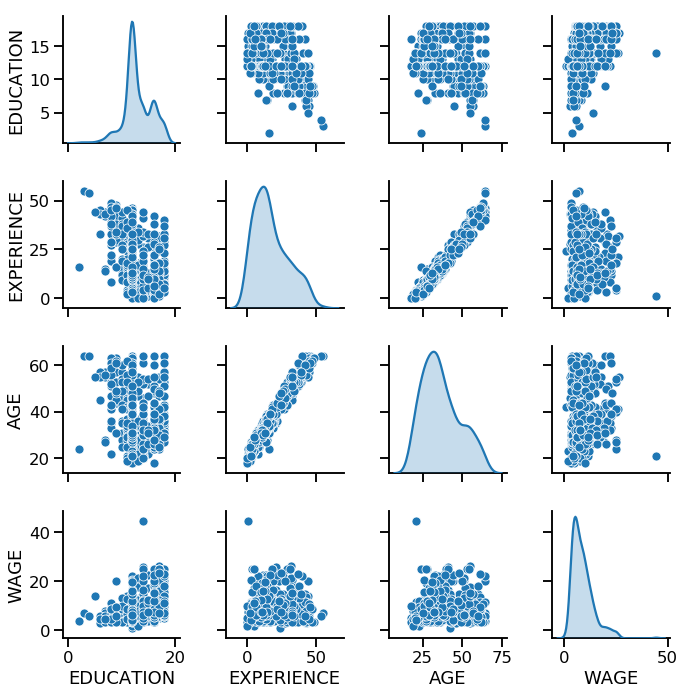

In [8]:
sns.pairplot(censing.data, diag_kind='kde');

We can add some additional information to the previous plots.

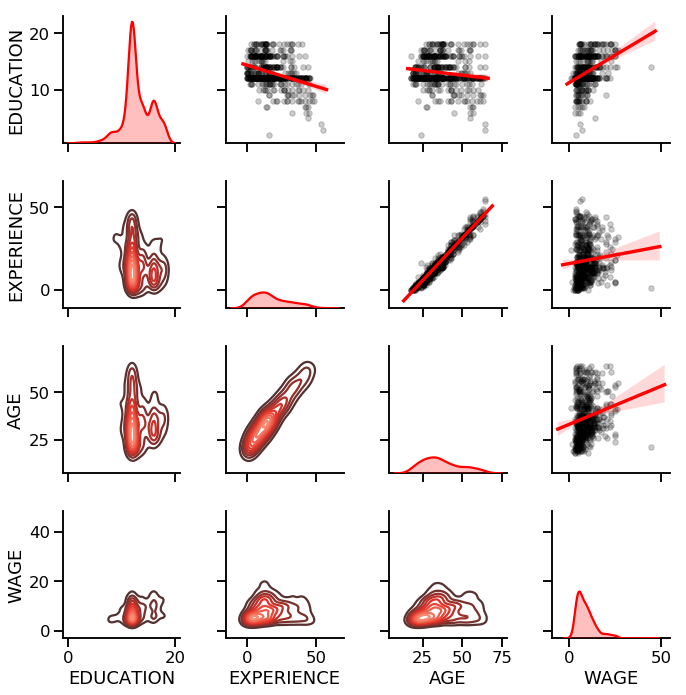

In [9]:
g = sns.PairGrid(censing.data)
g = g.map_upper(
    sns.regplot, scatter_kws={"color": "black", "alpha": 0.2, "s": 30},
    line_kws={"color": "red"}
)
g = g.map_lower(sns.kdeplot, cmap="Reds_d")
g = g.map_diag(sns.kdeplot, shade=True, color='r')

We can already have some intuitions regarding our dataset:

* The "WAGE" distribution has a long tail and we could work by taking the `log` of the wage;
* For all 3 variables, "EDUCATION", "EXPERIENCE", and "AGE", the "WAGE" is increasing when these variables are increasing;
* The "EXPERIENCE" and "AGE" are correlated.

It is important to point out that we analyzed the data by looking at the joint distribution between 2 variables which is a **marginal** link.

We will shortly jump into interpreting the coefficients of linear model. In this regard, we should emphasize that linear models compute **conditional** links. All interpretation of the value coefficient given the relationship between the feature and the target given that other features remain constant. For instance, we can deduce the relationship between the "AGE" and "WAGE" for a given number of year of "EXPERIENCE".

## Interpret coefficients of linear models

In [10]:
X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

We have heterogeneous data and we will need to make a specific preprocessing for each data types.

In [12]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

Thus, the `preprocessor` will:

* one-hot encode (i.e., generate a column by category) the categorical columns;
* replace by 0 and 1 the categories of binary columns;
* keep numerical values as they are.

We will fit a ridge regressor and transform the target before the fit using a log transform.

In [13]:
import numpy as np
import scipy as sp
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train);

We can check the performance of the model which fitted.

In [14]:
from sklearn.metrics import median_absolute_error

y_pred = model.predict(X_test)
print(f'MAE = {median_absolute_error(y_test, y_pred):.2f} $/hour')

MAE = 2.07 $/hour


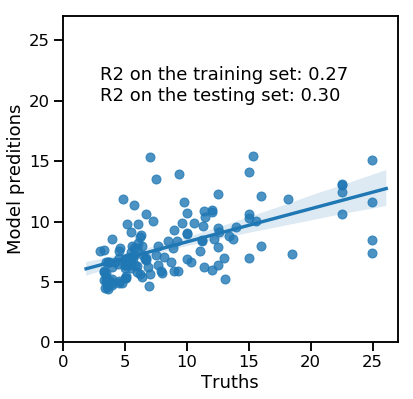

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(y_test, y_pred)

r2 = (f'R2 on the training set: {model.score(X_train, y_train):.2f}\n'
      f'R2 on the testing set: {model.score(X_test, y_test):.2f}')
plt.text(3, 20, r2)

plt.ylabel('Model preditions')
plt.xlabel('Truths')
plt.xlim([0, 27])
plt.ylim([0, 27]);

The model learnt is far to be a good model making accurate prediction. Interpretation tools are characterizing model rather than the generative process of the data itself. Thus, interpretations are correct if the model is correct as well.

So now, we can plot the values of the coefficients of the regressor which we fitted.

In [16]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

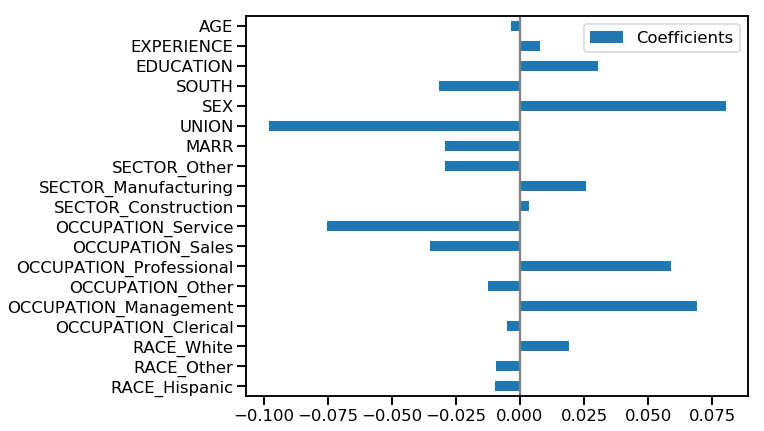

In [17]:
import pandas as pd

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5');

One limitation is that we cannot compare the different weights since we did not scale the data during fit and that features can have different range. For instance, the "AGE" coefficient is expressed in `$/hours/leaving years` while the "EDUCATION" is expressed in `$/hours/years of education`.

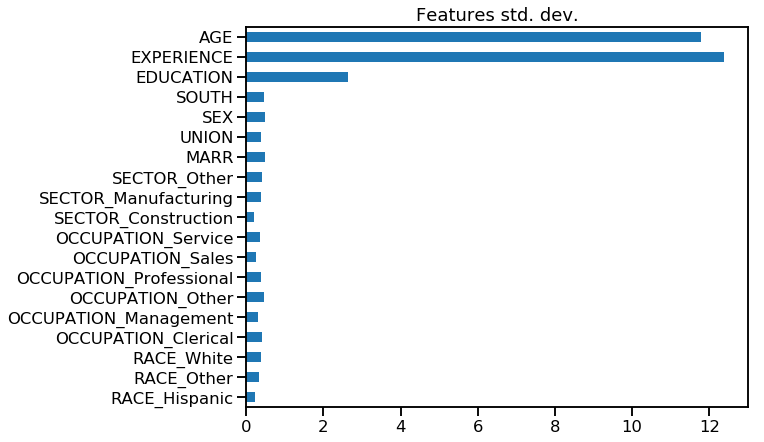

In [18]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)
X_train_preprocessed.std().plot(kind='barh', figsize=(9, 7))
plt.title('Features std. dev.');

We can normalize the weights by the standard deviation and then we will be able to compare the different weights.

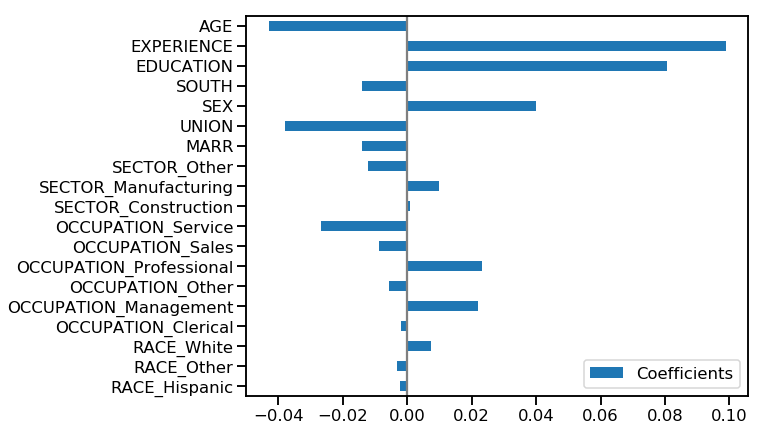

In [19]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train_preprocessed.std(),
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5');

The way that we can interpret these values is as follow. An increase of the "AGE" will induce a decrease of the "WAGE" when all other features remain constant or an increase of the "EXPERIENCE" will induce an increase of the "WAGE" when all other features remain constant.

The first interpretation might look counter-intuitive at first, if one relates the relationship between "AGE" and "WAGE" as a *marginal* link. However, as previously mentioned, a linear model computes a *conditional* link between "AGE" and "WAGE" given all other features.

Therefore, one could interpret that for a given experience (and all other features constant as well ...), a younger person would have an higher wage.

Up to now, we did not check the stability of the coefficients and it would be important to check it to ensure through cross-validation.

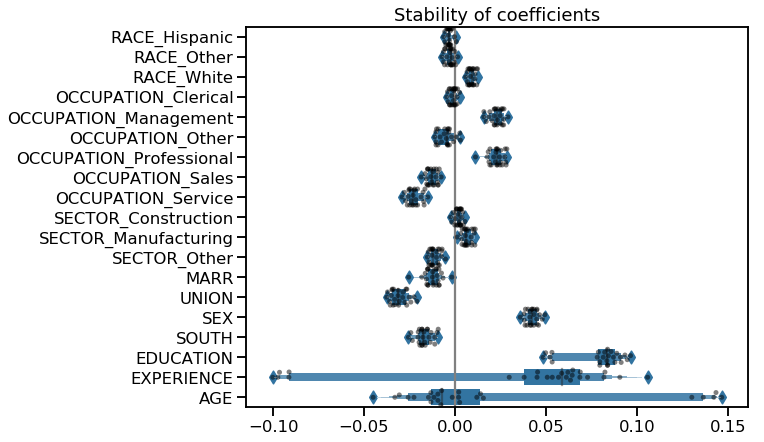

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std()
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxenplot(data=coefs, orient='h', color='C0')
plt.axvline(x=0, color='.5')
plt.title('Stability of coefficients');

The "AGE" and "EXPERIENCE" are highly instable which might be due to the collinearity between the 2 features. We can remove on of the 2 features and check what is the impact on the features stability.

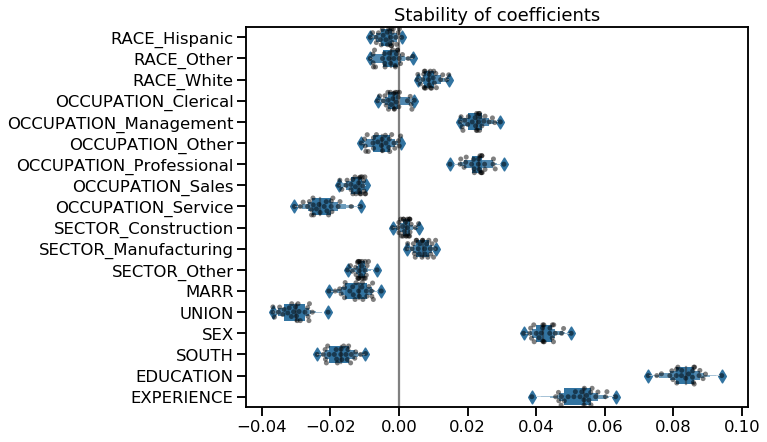

In [21]:
column_to_drop = ['AGE']

cv_model = cross_validate(
    model, X.drop(columns=column_to_drop), y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.drop(columns=column_to_drop).std()
     for est in cv_model['estimator']],
    columns=feature_names[:-1]
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxenplot(data=coefs, orient='h', color='C0')
plt.axvline(x=0, color='.5')
plt.title('Stability of coefficients');

With real-life dataset, data are leaving in a high-dimensional space where features are correlated and to make thing more difficult, we can have a limited number of samples. In this condition, estimating the coefficients is really difficult and we use regularization.

Ridge implements a $l_2$ regularization and we could use instead lasso which uses $l_1$. Lasso will select a subgroup of variable. However, it will be instable.

In [22]:
from sklearn.linear_model import LassoCV

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(max_iter=10000, cv=5),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train);

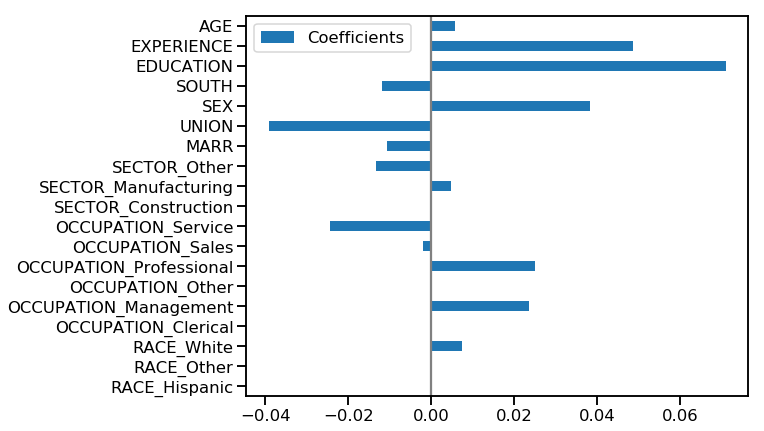

In [23]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train_preprocessed.std(),
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5');

We can observed that some of the variables have been dropped. We can now check the stability of the coefficients.

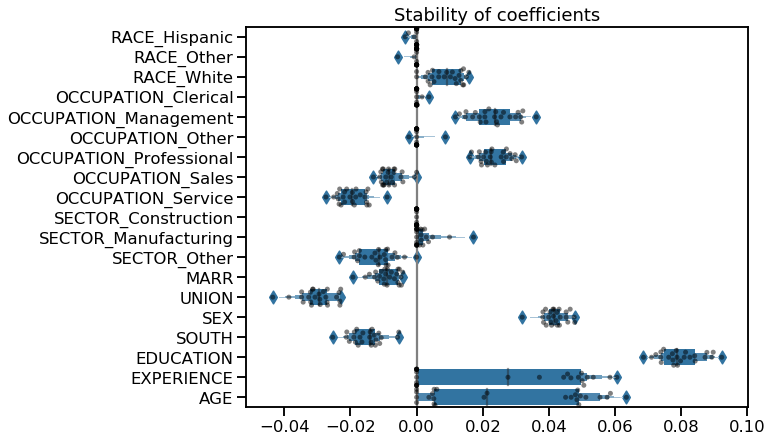

In [24]:
cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std()
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxenplot(data=coefs, orient='h', color='C0')
plt.axvline(x=0, color='.5')
plt.title('Stability of coefficients');

### Take-home message

* linear model coefficients represent conditional link between a variable and the target;
* coefficients cannot be compared if they were not normalized;
* regularization will be used when a problem starts to be complexed;
* collinearity makes interpretation difficult;
* interpretations charactized the model learnt rather than the process that generated the data.

## Interpret tree-based models

In the following section, we will focus on the so-called "feature importance". Feature importance are primilarly known for the tree-based algorithms. It is based on the fraction of samples a feature contributes to combined with the decrease in impurity from splitting them. However, we will see that this implementation suffers from some bias which we will highlight. To highlight the drawback of the random forest feature importances, we will add 2 random features (1 categorical feature and 1 numerical feature).

In [25]:
X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()

X['random_cat'] = np.random.randint(3, size=X.shape[0])
X['random_num'] = np.random.randn(X.shape[0])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

### Random Forest feature importances of an overfitted model

First, we will fit a random forest model. On purpose, we will grow each tree in the forest until each sample will be in a leaf. It implies that each tree will overfit. It allows us to highlight the issues of the feature importance computed in random forest.

In [27]:
from sklearn.ensemble import RandomForestRegressor

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR', 'random_cat']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE', 'random_num']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

model = make_pipeline(
    preprocessor,
    RandomForestRegressor(min_samples_leaf=1, random_state=42)
)
model.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % model.score(X_train, y_train))
print("RF test accuracy: %0.3f" % model.score(X_test, y_test))

RF train accuracy: 0.886
RF test accuracy: 0.233


We are getting a very high training compared to the testing score which is synonymous of having a model which overfits.

In [28]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

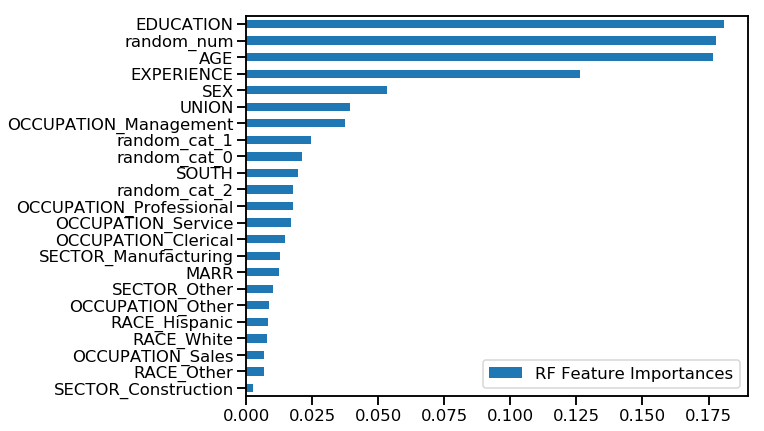

In [29]:
tree_feature_importances = pd.DataFrame(
    model.named_steps['randomforestregressor'].feature_importances_,
    index=feature_names,
    columns=['RF Feature Importances']
)
(tree_feature_importances.sort_values(by='RF Feature Importances')
                         .plot(kind='barh', figsize=(9, 7)));

The random forest feature importance reports that "random_num" is one of the most important feature. This results is surprising since this features does not have an predictive power. We can see the same behaviour with the "random_cat_2" which has an higher importance than than the other categorical features. This behavior is due to the bias linked with the cardinality of the unique values in a feature. Indeed, an higher cardinality induces that you have more chance to use this feature to make a split within the tree. Therefore, the numerical feature will have an higher importance than the categorical feature. Secondly, random feature will appear important when a model is overfitted.

### Permutation importances on the test set

Instead of using the random feature importance, one should use the "permutation importance" which is a different way to characterize the importance of feature using random permutation. To know the predictive power of a feature, we can permutate the value for a single feature and compute the decrease in accuracy. If the feature is a predictive feature then the decrease of accuracy will be higher. We can repeat the permutation several time to have an estiamate of the variance of the importances.

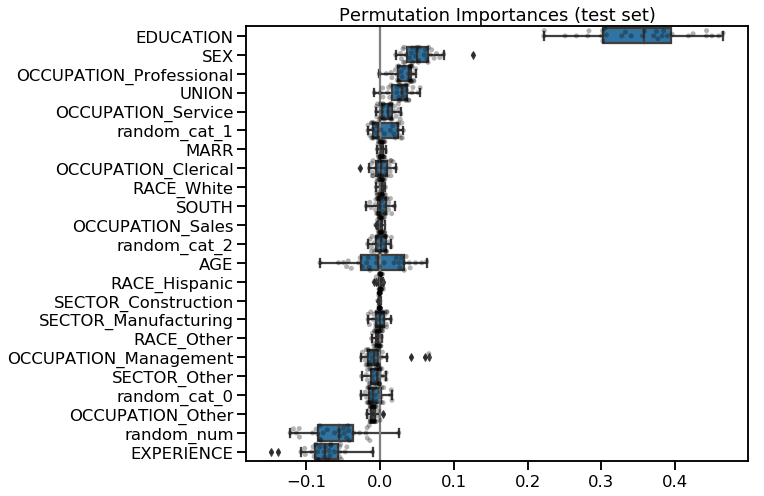

In [30]:
from sklearn.inspection import permutation_importance

X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_test_preprocessed, y_test, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (test set)");

Computing the permutation feature importance, we see that the random feature are not ranking in the top feature anymore. However, we can see that "EXPERIENCE" is on the bottom of the ranking. It is due to the collinearity with the "AGE" feature. We will see later on what would be the impact on removing one of the correlated feature.

### Permutation importances on the training set

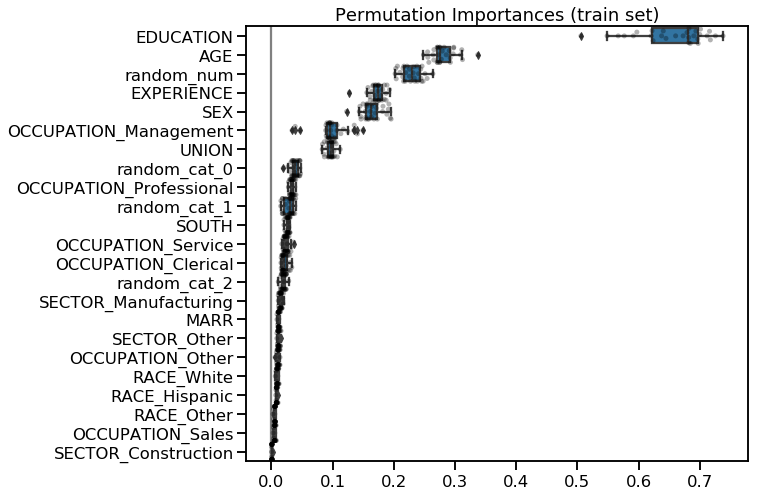

In [31]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_train_preprocessed, y_train, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (train set)");

### Same analysis on a non-overfitted model

In the previous example, we made the random forest overfit on the training data on purpose to exacerbate the behavior of the feature importance. We can now fit a model which should less overfit by increasing the number of samples required to create a leaf in the tree.

In [32]:
model.set_params(randomforestregressor__min_samples_leaf=10)
model.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % model.score(X_train, y_train))
print("RF test accuracy: %0.3f" % model.score(X_test, y_test))

RF train accuracy: 0.426
RF test accuracy: 0.363


The training accuracy decreased dratiscally and our model is not overfitting as before.

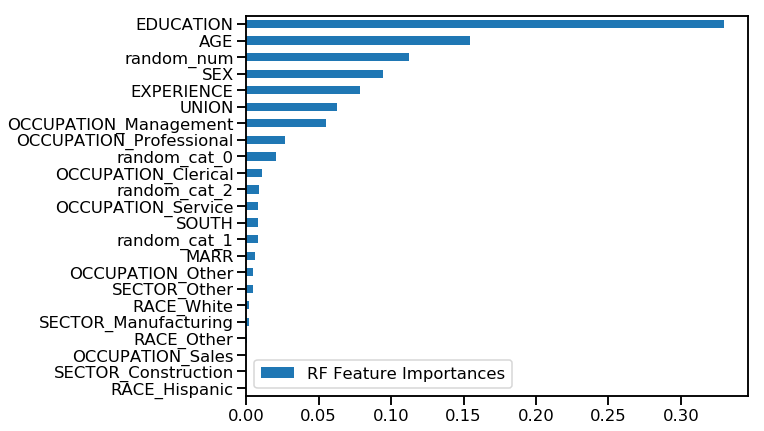

In [33]:
tree_feature_importances = pd.DataFrame(
    model.named_steps['randomforestregressor'].feature_importances_,
    index=feature_names,
    columns=['RF Feature Importances']
)
(tree_feature_importances.sort_values(by='RF Feature Importances')
                         .plot(kind='barh', figsize=(9, 7)));

We can see that the random feature does not rank as high as before but are still considered important. we can compute the permutation importance to see if there is a change of behaviour.

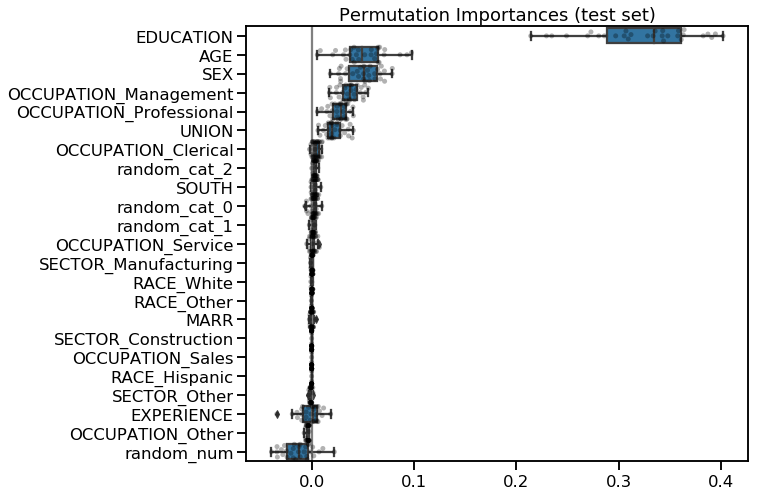

In [34]:
permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_test_preprocessed, y_test, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (test set)");

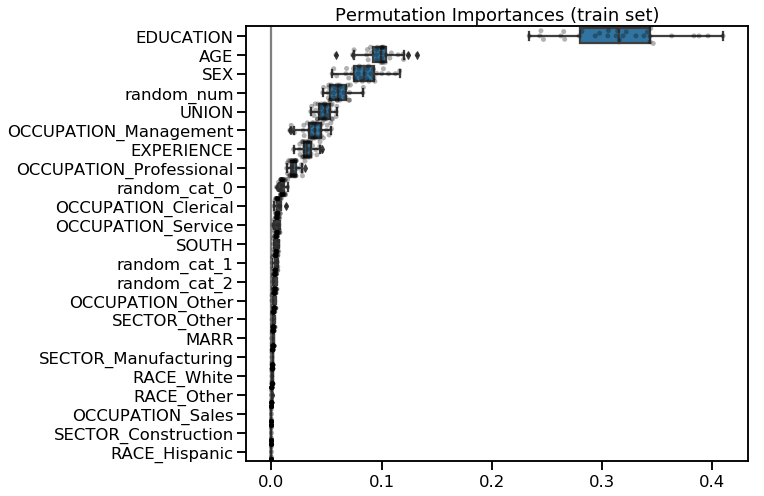

In [35]:
permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_train_preprocessed, y_train, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (train set)");

We see that the feature importance using the permutation is more stable and really similar to the first example.

### Remove collinear variables

We also saw that we have an issue with the importance of the "EXPERIENCE" feature which does not rank high in the importance. We thought that it could be linked to the fact that this feature is correlated with the "AGE" feature. We could drop one of the feature and check the impact on the feature importance.

In [36]:
column_to_drop = ['AGE', 'random_num']

In [37]:
model.fit(X_train.drop(columns=column_to_drop), y_train)

print("RF train accuracy: %0.3f" % model.score(X_train.drop(columns=column_to_drop), y_train))
print("RF test accuracy: %0.3f" % model.score(X_test.drop(columns=column_to_drop), y_test))

RF train accuracy: 0.398
RF test accuracy: 0.396


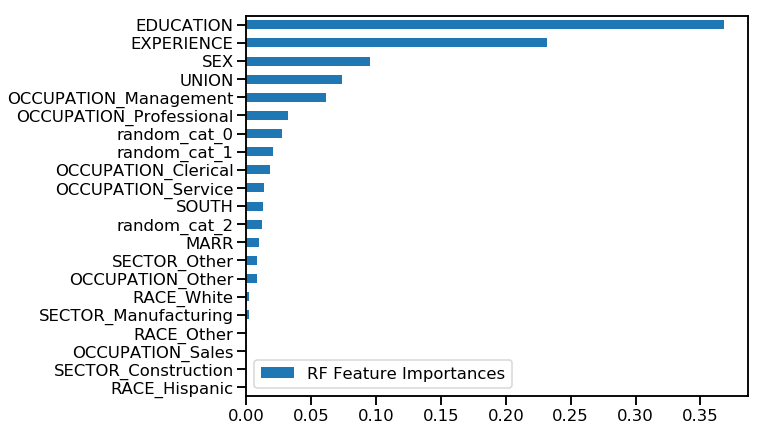

In [38]:
tree_feature_importances = pd.DataFrame(
    model.named_steps['randomforestregressor'].feature_importances_,
    index=feature_names[:-2],
    columns=['RF Feature Importances']
)
(tree_feature_importances.sort_values(by='RF Feature Importances')
                         .plot(kind='barh', figsize=(9, 7)));

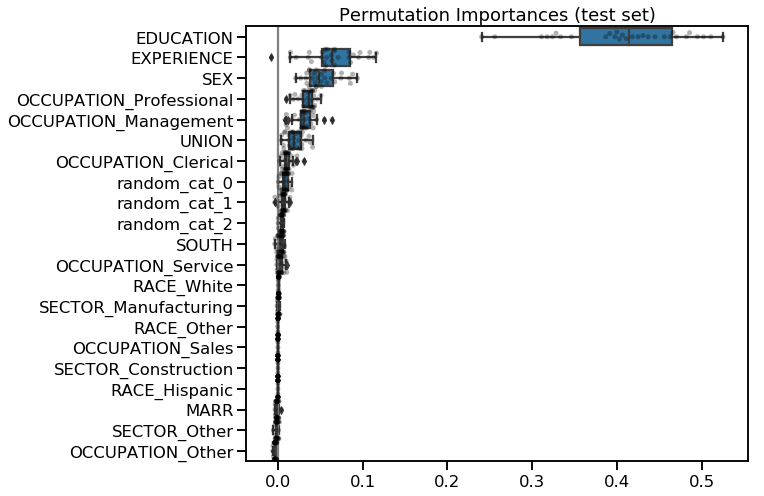

In [39]:
X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test.drop(columns=column_to_drop)))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_test_preprocessed, y_test, n_rounds=30),
    index=feature_names[:-2]
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (test set)");

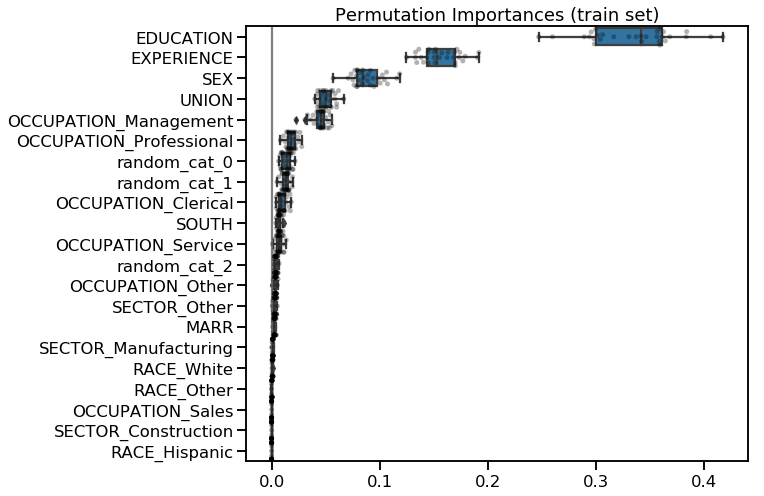

In [40]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train.drop(columns=column_to_drop)))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_train_preprocessed, y_train, n_rounds=30),
    index=feature_names[:-2]
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (train set)");

We can see that the "EXPERIENCE" feature starts to be more important. This behaviour is one of the drawback of the permutation importance. If permuting a feature which is correlated with another, there a chance for the model to use the correlated feature to make the decision. Subsquently, there is no decrease of accuracy hidding the importance of this feature. This is one of the limitation of the permutation feature importance.

**TODO: refer to the example of the PR using the correlation/clustering**

### Permutation importance for other type of models

The permutation importance can be computed for every type of model. Let's demonstrate with our original ridge model.

In [41]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train);

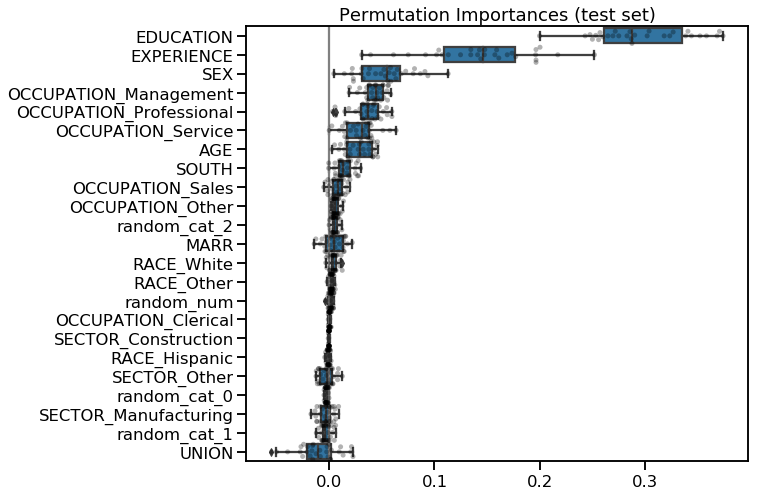

In [42]:
X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['transformedtargetregressor'],
                           X_test_preprocessed, y_test, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (test set)");

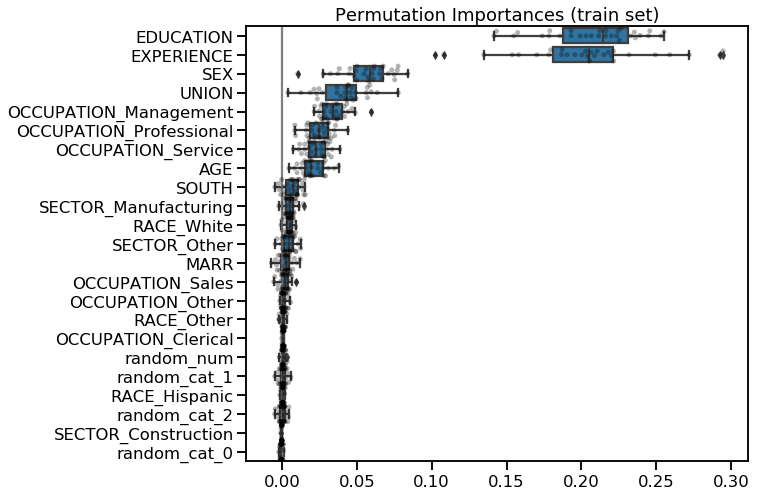

In [43]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['transformedtargetregressor'],
                           X_train_preprocessed, y_train, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (train set)");

### Take-home message

* random forest feature importances suffer from bias;
* permutation importances allievate these issues;
* permutation importances will minimize the importance of correlated features;
* permutation importances is model agnostic.

## Partial Dependence Plot

In [44]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

model = make_pipeline(
    preprocessor,
    HistGradientBoostingRegressor(max_iter=100, max_leaf_nodes=64,
                                  learning_rate=0.1, random_state=1)
)
model.fit(X_train, y_train)
print("Test R2 score: {:.2f}".format(model.score(X_test, y_test)))

Test R2 score: 0.30


In [45]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

In [46]:
feature_names

array(['RACE_Hispanic', 'RACE_Other', 'RACE_White', 'OCCUPATION_Clerical',
       'OCCUPATION_Management', 'OCCUPATION_Other',
       'OCCUPATION_Professional', 'OCCUPATION_Sales',
       'OCCUPATION_Service', 'SECTOR_Construction',
       'SECTOR_Manufacturing', 'SECTOR_Other', 'MARR', 'UNION', 'SEX',
       'SOUTH', 'EDUCATION', 'EXPERIENCE', 'AGE'], dtype=object)

In [47]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train))
X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test))

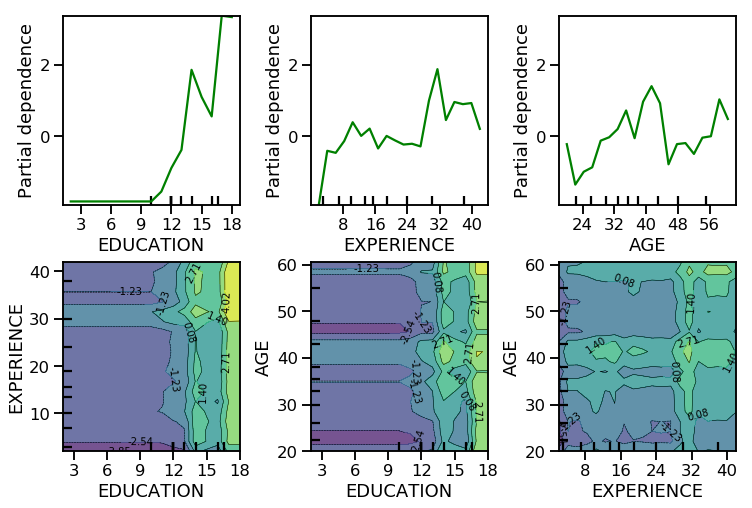

In [48]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize=(11, 11))
features = [16, 17, 18, (16, 17), (16, 18), (17, 18)]
plot_partial_dependence(
    model.named_steps['histgradientboostingregressor'],
    X_train_preprocessed, features, feature_names=feature_names,
    n_jobs=-1, grid_resolution=20, fig=fig
)

In [49]:
X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

model = make_pipeline(
    preprocessor,
    RandomForestRegressor(random_state=1)
)
model.fit(X_train, y_train)
print("Test R2 score: {:.2f}".format(model.score(X_test, y_test)))

Test R2 score: 0.24


In [50]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

In [51]:
feature_names

array(['RACE_Hispanic', 'RACE_Other', 'RACE_White', 'OCCUPATION_Clerical',
       'OCCUPATION_Management', 'OCCUPATION_Other',
       'OCCUPATION_Professional', 'OCCUPATION_Sales',
       'OCCUPATION_Service', 'SECTOR_Construction',
       'SECTOR_Manufacturing', 'SECTOR_Other', 'MARR', 'UNION', 'SEX',
       'SOUTH', 'EDUCATION', 'EXPERIENCE', 'AGE'], dtype=object)

In [52]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train))
X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test))

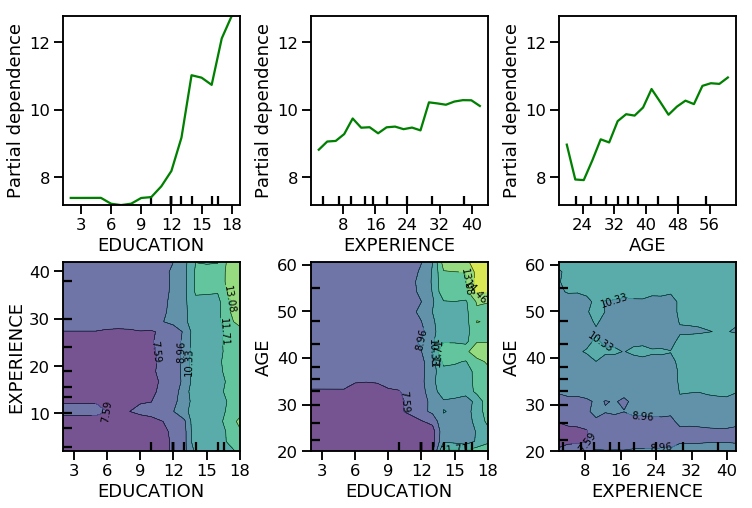

In [53]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize=(11, 11))
features = [16, 17, 18, (16, 17), (16, 18), (17, 18)]
plot_partial_dependence(
    model.named_steps['randomforestregressor'],
    X_train_preprocessed, features, feature_names=feature_names,
    n_jobs=-1, grid_resolution=20, fig=fig
)

In [54]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

model = make_pipeline(
    preprocessor,
    MLPRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=0.01,
                 max_iter=200,
                 early_stopping=True,
                 n_iter_no_change=10,
                 validation_fraction=0.1)
)
model.fit(X_train, y_train)
print("Test R2 score: {:.2f}".format(model.score(X_test, y_test)))

Test R2 score: 0.19


In [55]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

In [56]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train))
X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test))

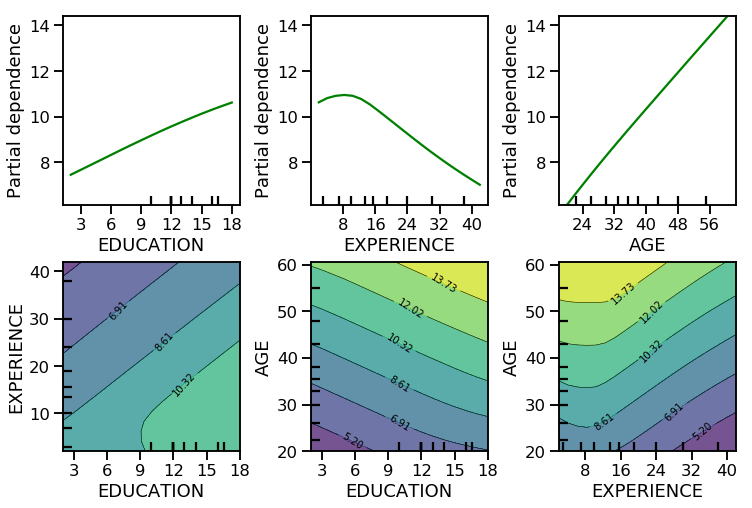

In [57]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize=(11, 11))
features = [16, 17, 18, (16, 17), (16, 18), (17, 18)]
plot_partial_dependence(
    model.named_steps['mlpregressor'],
    X_train_preprocessed, features, feature_names=feature_names,
    n_jobs=-1, grid_resolution=20, fig=fig
)

## Appendix

### Effect plots for linear models

In [58]:
from sklearn.preprocessing import StandardScaler

X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    (StandardScaler(), numerical_columns)
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train);

In [59]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

We can check the effect of the coefficients on the original data by multiplying the coefficients of the linear model by the original data (preprocessed).

In [60]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)
effect = X_train_preprocessed * model.named_steps['transformedtargetregressor'].regressor_.coef_

# For the categorical variable, we can inverse the one-hot encoding since only one of the category will be non-null
effect_decoded = {}
for cat in categorical_columns:
    cat_cols = effect.columns.str.contains(cat)
    effect_cat = effect.loc[:, cat_cols]
    idx_filter = (effect_cat != 0).values
    effect_decoded[cat] = effect_cat.values[idx_filter]
# For the other columns, we don't need to inverse any embedding
for col in binary_columns + numerical_columns:
    effect_decoded[col] = effect[col]
effect = pd.DataFrame(effect_decoded)

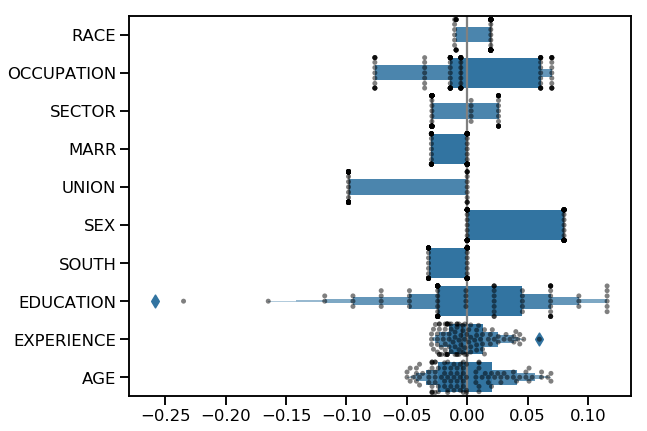

In [61]:
plt.figure(figsize=(9, 7))
# subsample for the swarmplot
sns.swarmplot(data=effect.sample(100), orient='h', color='k', alpha=0.5)
sns.boxenplot(data=effect, orient='h', color='C0')
plt.axvline(x=0, color='.5');

The largest contribution to the expected wages is related to the "EDUCATION" due to the large variance in the effect plot.

## References

[1] Interpretable Machine Learning, Christph Molnar, 2019. https://github.com/christophM/interpretable-ml-book

[2] Beware Default Random Forest Importances, Terence Parr et al., 2018. https://explained.ai/rf-importance/